In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camjt\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\camjt\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.9.1


In [2]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [3]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())


[5 6 7 8] [9]
[2 3 4 5] [6]
[4 5 6 7] [8]
[3 4 5 6] [7]
[0 1 2 3] [4]
[1 2 3 4] [5]


In [5]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]
x =  [[5 6 7 8]
 [3 4 5 6]]
y =  [[9]
 [7]]
x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

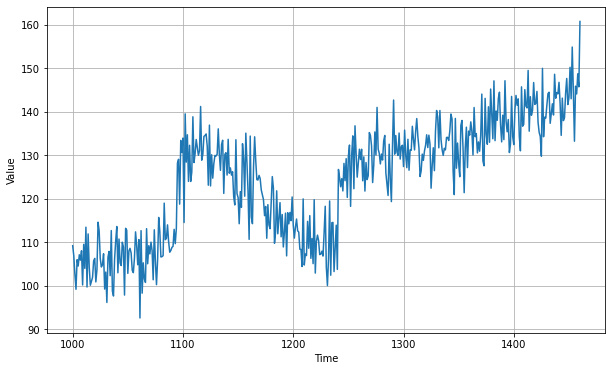

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[37.39699  37.309628 25.211407 27.470016 34.793957 34.847603 34.914043
  51.662838 35.31426  38.198494 37.351772 35.90006  31.128325 36.56132
  28.964384 31.70668  30.526445 33.42535  44.65221  23.805752]], shape=(1, 20), dtype=float32)
tf.Tensor([36.63676], shape=(1,), dtype=float32)


In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)



Epoch 1/100


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 2s 42ms/step - loss: 115.2880
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 42.8904
Epoch 3/100
31/31 [==============================] - 0s 953us/step - loss: 41.8872
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 41.8737
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 41.6703
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 41.8539
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 41.9954
Epoch 8/100
31/31 [==============================] - 0s 909us/step - loss: 41.9042
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 41.1367
Epoch 10/100
31/31 [==============================] - 0s 858us/step - loss: 40.8379
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 41.0915
Epoch 12/100
31/31 [==============================] - 0s 890us/step - loss: 41.1767
Epoch 13/100
31/31 [=======

31/31 [==============================] - 0s 1ms/step - loss: 36.5951


In [12]:
start_point=1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(series[start_point:start_point+window_size][np.newaxis]))

print(series[1000:1020])
print(series[1020])
print(model.predict(series[1000:1020][np.newaxis]))


[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 92ms/step
[[104.69463]]
[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 18ms/step
[[104.69463]]


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


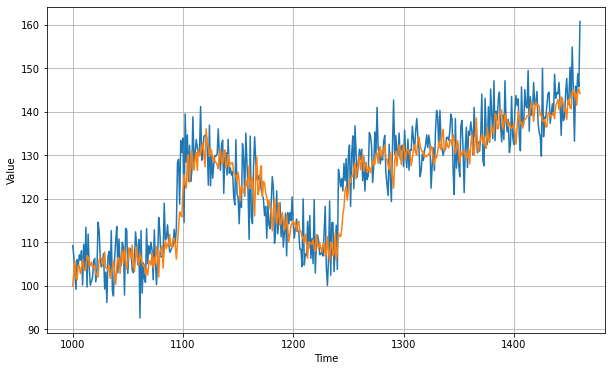

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.698586

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(1e-08, 0.001, 0.0, 300.0)

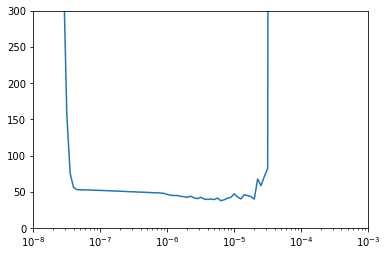

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 300.0)

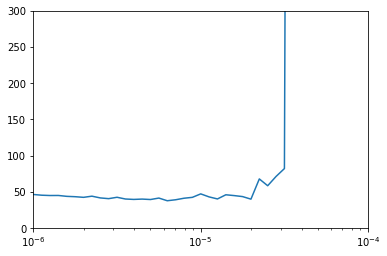

In [17]:
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 300])

In [18]:
window_size = 40
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


30/30 [==============================] - 0s 1ms/step - loss: 1045.0402
Epoch 2/500
30/30 [==============================] - 0s 1ms/step - loss: 131.9712
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 57.5598
Epoch 4/500
30/30 [==============================] - 0s 1ms/step - loss: 52.7675
Epoch 5/500
30/30 [==============================] - 0s 1ms/step - loss: 45.6391
Epoch 6/500
30/30 [==============================] - 0s 959us/step - loss: 42.3118
Epoch 7/500
30/30 [==============================] - 0s 1ms/step - loss: 53.4454
Epoch 8/500
30/30 [==============================] - 0s 1ms/step - loss: 66.3866
Epoch 9/500
30/30 [==============================] - 0s 891us/step - loss: 49.4599
Epoch 10/500
30/30 [==============================] - 0s 862us/step - loss: 43.6838
Epoch 11/500
30/30 [==============================] - 0s 844us/step - loss: 50.1251
Epoch 12/500
30/30 [==============================] - 0s 1ms/step - loss: 47.4636
Epoch 13/500
30/30 [======

30/30 [==============================] - 0s 1ms/step - loss: 36.1357
Epoch 101/500
30/30 [==============================] - 0s 2ms/step - loss: 44.7652
Epoch 102/500
30/30 [==============================] - 0s 1ms/step - loss: 36.3998
Epoch 103/500
30/30 [==============================] - 0s 967us/step - loss: 32.7448
Epoch 104/500
30/30 [==============================] - 0s 1ms/step - loss: 37.4947
Epoch 105/500
30/30 [==============================] - 0s 1ms/step - loss: 32.8357
Epoch 106/500
30/30 [==============================] - 0s 1ms/step - loss: 40.6199
Epoch 107/500
30/30 [==============================] - 0s 1ms/step - loss: 33.1791
Epoch 108/500
30/30 [==============================] - 0s 1ms/step - loss: 33.9906
Epoch 109/500
30/30 [==============================] - 0s 1ms/step - loss: 35.1265
Epoch 110/500
30/30 [==============================] - 0s 1ms/step - loss: 33.1664
Epoch 111/500
30/30 [==============================] - 0s 2ms/step - loss: 34.0556
Epoch 112/500
30

30/30 [==============================] - 0s 1ms/step - loss: 37.7732
Epoch 199/500
30/30 [==============================] - 0s 1ms/step - loss: 36.1484
Epoch 200/500
30/30 [==============================] - 0s 1ms/step - loss: 40.9958
Epoch 201/500
30/30 [==============================] - 0s 1ms/step - loss: 49.5646
Epoch 202/500
30/30 [==============================] - 0s 1ms/step - loss: 35.6892
Epoch 203/500
30/30 [==============================] - 0s 1ms/step - loss: 33.1517
Epoch 204/500
30/30 [==============================] - 0s 1ms/step - loss: 36.6820
Epoch 205/500
30/30 [==============================] - 0s 1ms/step - loss: 33.8165
Epoch 206/500
30/30 [==============================] - 0s 1ms/step - loss: 33.8532
Epoch 207/500
30/30 [==============================] - 0s 831us/step - loss: 35.2673
Epoch 208/500
30/30 [==============================] - 0s 945us/step - loss: 33.4438
Epoch 209/500
30/30 [==============================] - 0s 1ms/step - loss: 32.5522
Epoch 210/500


30/30 [==============================] - 0s 828us/step - loss: 35.7994
Epoch 297/500
30/30 [==============================] - 0s 806us/step - loss: 32.7674
Epoch 298/500
30/30 [==============================] - 0s 881us/step - loss: 32.2662
Epoch 299/500
30/30 [==============================] - 0s 837us/step - loss: 32.6040
Epoch 300/500
30/30 [==============================] - 0s 953us/step - loss: 33.0459
Epoch 301/500
30/30 [==============================] - 0s 2ms/step - loss: 34.3452
Epoch 302/500
30/30 [==============================] - 0s 1ms/step - loss: 31.3336
Epoch 303/500
30/30 [==============================] - 0s 919us/step - loss: 31.7649
Epoch 304/500
30/30 [==============================] - 0s 1ms/step - loss: 35.8014
Epoch 305/500
30/30 [==============================] - 0s 1ms/step - loss: 37.0922
Epoch 306/500
30/30 [==============================] - 0s 1ms/step - loss: 37.9567
Epoch 307/500
30/30 [==============================] - 0s 2ms/step - loss: 32.7843
Epoch 

30/30 [==============================] - 0s 926us/step - loss: 35.6819
Epoch 395/500
30/30 [==============================] - 0s 1ms/step - loss: 32.6659
Epoch 396/500
30/30 [==============================] - 0s 877us/step - loss: 33.1556
Epoch 397/500
30/30 [==============================] - 0s 2ms/step - loss: 32.0194
Epoch 398/500
30/30 [==============================] - 0s 3ms/step - loss: 30.5414
Epoch 399/500
30/30 [==============================] - 0s 1ms/step - loss: 31.9942
Epoch 400/500
30/30 [==============================] - 0s 924us/step - loss: 35.0329
Epoch 401/500
30/30 [==============================] - 0s 892us/step - loss: 31.4575
Epoch 402/500
30/30 [==============================] - 0s 922us/step - loss: 35.5752
Epoch 403/500
30/30 [==============================] - 0s 1ms/step - loss: 33.6875
Epoch 404/500
30/30 [==============================] - 0s 2ms/step - loss: 31.1315
Epoch 405/500
30/30 [==============================] - 0s 2ms/step - loss: 32.5159
Epoch 40

Epoch 492/500
30/30 [==============================] - 0s 1ms/step - loss: 33.1250
Epoch 493/500
30/30 [==============================] - 0s 1ms/step - loss: 33.8503
Epoch 494/500
30/30 [==============================] - 0s 1ms/step - loss: 35.7899
Epoch 495/500
30/30 [==============================] - 0s 2ms/step - loss: 34.5953
Epoch 496/500
30/30 [==============================] - 0s 2ms/step - loss: 31.7199
Epoch 497/500
30/30 [==============================] - 0s 1ms/step - loss: 32.7928
Epoch 498/500
30/30 [==============================] - 0s 1ms/step - loss: 33.3912
Epoch 499/500
30/30 [==============================] - 0s 989us/step - loss: 31.6627
Epoch 500/500
30/30 [==============================] - 0s 803us/step - loss: 30.9650


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


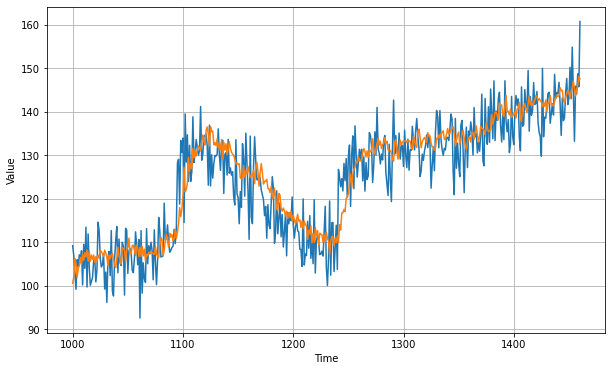

In [19]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.812924